# Import packages

In [69]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai

In [70]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# Case 4: Hospital_accessibility
task_name ='Hospital_accessibility'

TASK = r'''
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map, also show the hospital.
'''

# TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

DATA_LOCATIONS = [
r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, map projection is WGS1984.",
r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
]

  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map, also show the hospital.
 
Location for data you may need: 1. SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, map projection is WGS1984.
2. SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column. 
Your reply needs to meet these requirements: 
 1. DO NOT change the given variable names and paths.
2. Put your reply into a Python code block(enclosed by ```python and ```), NO explanation or conversation outside the code block.
3. If using GeoPan

```python
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
from geopy.distance import great_circle

# Read zipped shapefile from URL
sc_zip_bndry_url = "https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip"
zip_bndry_gdf = gpd.read_file(sc_zip_bndry_url)

# Read hospital table
sc_hospitals_url = "https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv"
hospitals_df = pd.read_csv(sc_hospitals_url)

# Convert hospitals df to gdf
hospitals_gdf = gpd.GeoDataFrame(hospitals_df, geometry=gpd.points_from_xy(hospitals_df.POINT_X, hospitals_df.POINT_Y), crs="EPSG:4326")

# Reproject hospital data to match the zip boundary gdf's projection
hospitals_gdf = hospitals_gdf.to_crs(zip_bndry_gdf.crs)

# Calculate the centroid of zip code polygons
zip_bndry_gdf['centroid'] = zip_bndry_gdf.geometry.centroid

# Function for finding close

<string>:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

100%|███████████████████████████████████████████████████████████████████████████████| 424/424 [00:01<00:00, 219.85it/s]


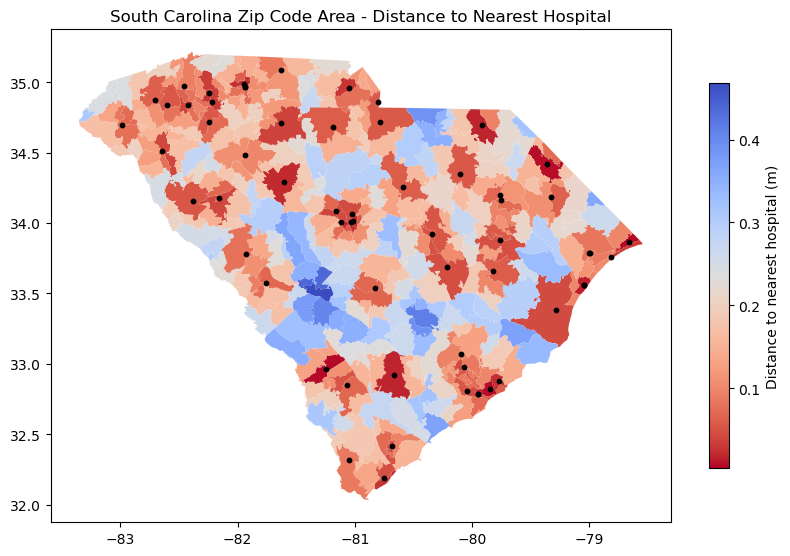

In [72]:
direct_request_LLM_response = solution.get_direct_request_LLM_response()
exec(solution.direct_request_code)